In [1]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt
import socket
import scipy.signal as signal

# Offline berechnung

# Dastellung im Frequenzbereich
Um die Signale im Frequenzberich abbilden zu können, wird ein Spectrogramm benötigt, welche falblich die Signalsstärke anzeigt, sowie auf de nAchsen das Freqeunsspektrum und die Anzahl der Abtastungen

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 64
    ts = 2
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()

def display_spectrogram_if_signal(x,signal_strength):
    fftlen = 1024
    ts = 8
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    if(z.max() >= signal_strength):
        # display spectrum
        levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
        cmap = plt.get_cmap('PiYG')
        norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
        xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]               # yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
        fig = plt.figure()
        im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
        fig.colorbar(im,ax=fig.gca())
        fig.gca().set_title('spectrogram')
        plt.show()

In [3]:
# # loading Preambel
# filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\preamble.sig"
# n_float32 = int(stat(filename).st_size/4)
# with open(filename,"rb") as binary_file:
#     pre = array('f')
#     pre.fromfile(binary_file,n_float32)
# pre = np.array(pre.tolist()[::2])+1j*np.array(pre.tolist()[1::2])
# pre /= np.amax(np.abs(pre))      # normalize to 1
# pre -= np.mean(pre)              # remove DC
# print("signal size:",pre.shape[0])


# Referenzsignal
In einem externen Dokument können alle möglichen Symbole generiert werden. Diese werden dann benutzt, um diese mit dem augenommenen Signale zu vergleichen und übereitummungen zu erkennen.

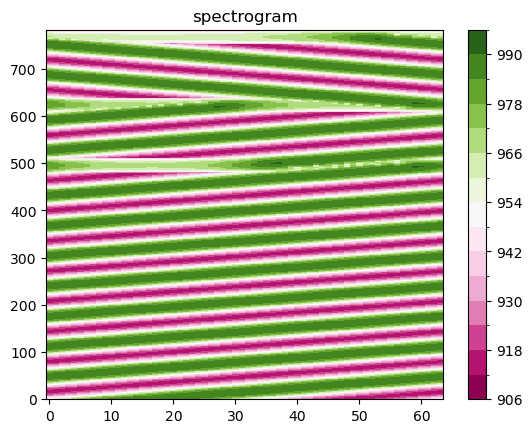

Size of a Zero Symbol: 128
Size of a Preamle Symbol: 1568


In [15]:
# Starterkennung
import Preambel as pre
SF = 7 # SpreadingFactor

zero = pre.GetUpchirp(SF)
preamble = pre.GetPreamble(SF)
display_spectrogram(preamble)
print(f"Size of a Zero Symbol: {len(zero)}")
print(f"Size of a Preamle Symbol: {len(preamble)}")

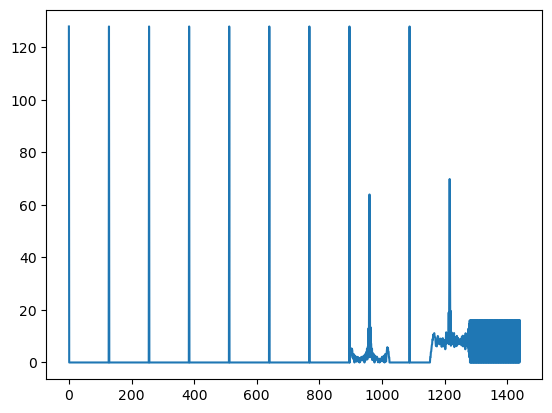

In [5]:
corr = np.correlate(preamble,zero)
plt.plot(abs(corr))
plt.show()

In [6]:
# Alternive für offline Signale 
def get_startpoint(signal_t,start_symbol,threshold):
    result = np.correlate(signal_t,start_symbol)
    Start_Position = np.argmax(np.array(result)>threshold)
    print(f"Startpunkt: {Start_Position}")
    return Start_Position

import Preambel as pre

def demod_symbols(signal_t):
    zero = pre.GetUpchirp(SF=7)                         # referencesignal
    STEP = len(zero)                                    # size of referencesignal
    
    # necessary ??
    # THRESHOLD = 100
    # index = Get_Startpoint(signal_t,zero,THRESHOLD)     # define startpoint
    # signal_t = signal_t[index:]                         # reduce to startpoint

    print(f"size of signal_t    : {len(signal_t)}")
    print(f"size of symbol zero : {STEP}")

    if len(signal_t) < STEP:
        return -1                                       # Error: signal to short

    pos = 0
    symbols = []
    index = []
    
    while len(signal_t) >= STEP:
        signal_td = np.multiply(signal_t[0:STEP],np.conj(zero))
        signal_f = abs(np.fft.fft(signal_td))
        symbols.append(round(max(signal_f)))
        index.append(pos*STEP + np.array(signal_f).argmax())
        signal_t = signal_t[STEP::]                      # shorten the array by a step
        pos += 1
                                   
    return index,symbols

def visualize_symbols(signal_t):
    index,symbols = Demod_Symbols(signal_t)
    plt.plot(index,symbols,'x',)
    plt.ylim([1, 2**SF*1.25])
    plt.grid()
    plt.xlabel("Samples")
    plt.ylabel("Symbol")
    plt.title("Demoduliertes Signal")
    plt.show()


In [7]:
def real_preamble(preamble:complex,sample_shift:int,frequency_shift:int) -> complex:
    # Timeshift
    preamble = np.roll(preamble,-sample_shift)

    # Frequencyshift
    frequency_shift = np.exp(2j*np.pi*range(len(preamble))*frequency_shift/128)
    preamble = np.multiply(preamble,frequency_shift)
    return preamble